In [52]:
import pandas as pd
import numpy as np
import pickle
import re
import scipy as sp

import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.neighbors import NearestNeighbors
from sklearn.neural_network import MLPClassifier

from collections import defaultdict

import matplotlib.pyplot as plt

from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
from statsmodels.stats.weightstats import ttest_ind

### Read data

In [53]:
recs_1 = pd.read_csv("../data/recommendations/recommendations_strat_1_clean.csv").drop("Unnamed: 0", axis=1)
recs_2 = pd.read_csv("../data/recommendations/recommendations_strat_2_clean.csv").drop("Unnamed: 0", axis=1)
recs_3 = pd.read_csv("../data/recommendations/recommendations_strat_3_clean.csv").drop("Unnamed: 0", axis=1)
recs_4 = pd.read_csv("../data/recommendations/recommendations_strat_4_clean.csv").drop("Unnamed: 0", axis=1).dropna()

In [54]:
equal = pd.read_csv("../data/training_videos.csv").drop("Unnamed: 0", axis = 1)
equal["full_text"].fillna("", inplace=True)

### Vectorize 

In [55]:
# Vectorize words
v = TfidfVectorizer(max_df=.75, min_df=2)
x = v.fit_transform(equal['full_text'])

In [56]:
X = x
Y = equal['conspiracy'].values.ravel()

### Train or load model

In [57]:
try:
    svm = pickle.load(open('SVM_trained.sav', 'rb'))
except:
    # Train
    svm = SVC(C=10, kernel="rbf", max_iter = 10000).fit(X, Y)

    # save the model to disk
    pickle.dump(svm, open('SVM_trained.sav', 'wb'))

In [58]:
try:
    mlp = pickle.load(open('MLP_trained.sav', 'rb'))
except:
    mlp = MLPClassifier(hidden_layer_sizes=[10]*10, activation="identity",
                        random_state=0).fit(X, Y)
    
    pickle.dump(mlp, open("MLP_trained.sav", 'wb'))

### Transform recommendations to tf-idf

In [59]:
recs_tfidf_1 = v.transform(recs_1["full_text"].values)
recs_tfidf_2 = v.transform(recs_2["full_text"].values)
recs_tfidf_3 = v.transform(recs_3["full_text"].values)
recs_tfidf_4 = v.transform(recs_4["full_text"].values)

### Predictions

In [60]:
predictions_1 = svm.predict(recs_tfidf_1)
predictions_2 = svm.predict(recs_tfidf_2)
predictions_3 = svm.predict(recs_tfidf_3)
predictions_4 = svm.predict(recs_tfidf_4)

In [61]:
predictions_1.mean(), predictions_2.mean(), predictions_3.mean(), predictions_4.mean()

(0.06619718309859154,
 0.25069444444444444,
 0.31733333333333336,
 0.377814845704754)

In [62]:
recs_1["conspiracy_pred"] = predictions_1
recs_2["conspiracy_pred"] = predictions_2
recs_3["conspiracy_pred"] = predictions_3
recs_4["conspiracy_pred"] = predictions_4

## Aggregates

In [113]:
recs_1["strategy"] = "strategy 1"
recs_2["strategy"] = "strategy 2"
recs_3["strategy"] = "strategy 3"
recs_4["strategy"] = "strategy 4"

In [114]:
combined = pd.concat([recs_1, recs_2, recs_3, recs_4], ignore_index=True)

In [115]:
# Select useful columns
combined = combined[["user", "strategy", "vids_watched",
                     "views", "likes", "dislikes",
                     "duration", "conspiracy_pred"]].copy()

In [116]:
def to_seconds(duration):
    times = re.findall("\d+", duration)[::-1]
    return sum([int(times[i]) * 60**i for i in range(len(times))])

In [117]:
# Convert time to seconds
combined["duration"] = combined["duration"].apply(lambda x: to_seconds(str(x)))

In [118]:
# Group
grouped = combined.groupby(["strategy", "vids_watched"])

## Pivot and plot

In [119]:
sns.set_theme(style="whitegrid")

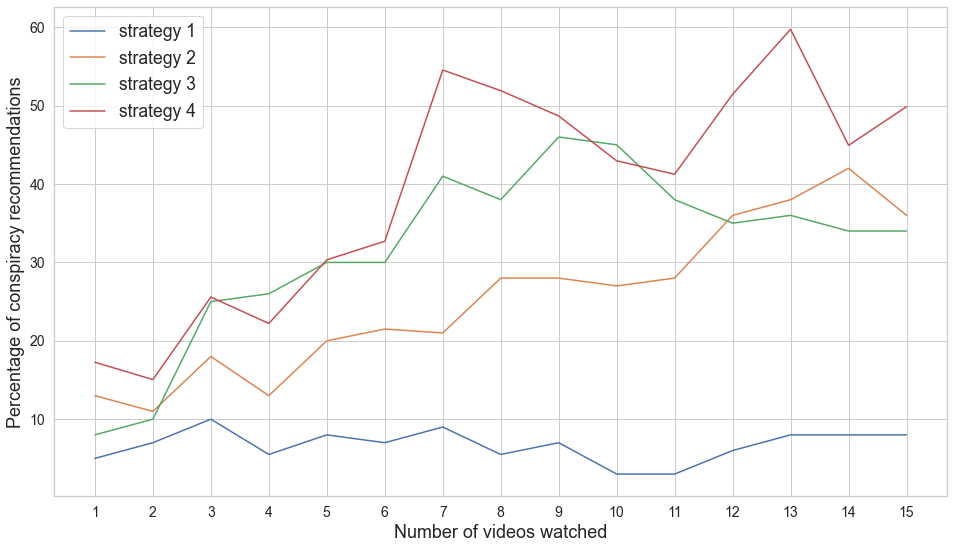

In [218]:
# Pivot
pivot = pd.pivot_table(combined,
                       index = ("strategy", "user"),
                       columns = "vids_watched",
                       values = "conspiracy_pred",
                       aggfunc = np.mean)

# Fill na with average of previous and next cell in column
pivot = (pivot.fillna(method="ffill", axis = 1) + pivot.fillna(method="bfill", axis = 1)) / 2 
pivot = (pivot.fillna(method="ffill", axis = 1) + pivot.fillna(method="bfill", axis = 1)) / 2 

grouped = pivot.groupby("strategy").mean()

# Plot
plt.figure(figsize=(16,9))

x = grouped.columns
y = grouped.values * 100
labels = ["strategy 1", "strategy 2", "strategy 3", "strategy 4"]

for y_val, label in zip(y, labels):
    plt.plot(x, y_val, label=label);

plt.xticks(np.arange(1, 16, 1), fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("Number of videos watched", fontsize=18);
plt.ylabel("Percentage of conspiracy recommendations", fontsize=18);

plt.legend(loc="upper left", prop = {"size": 17.5})
plt.show()

### Split strategy into individual users

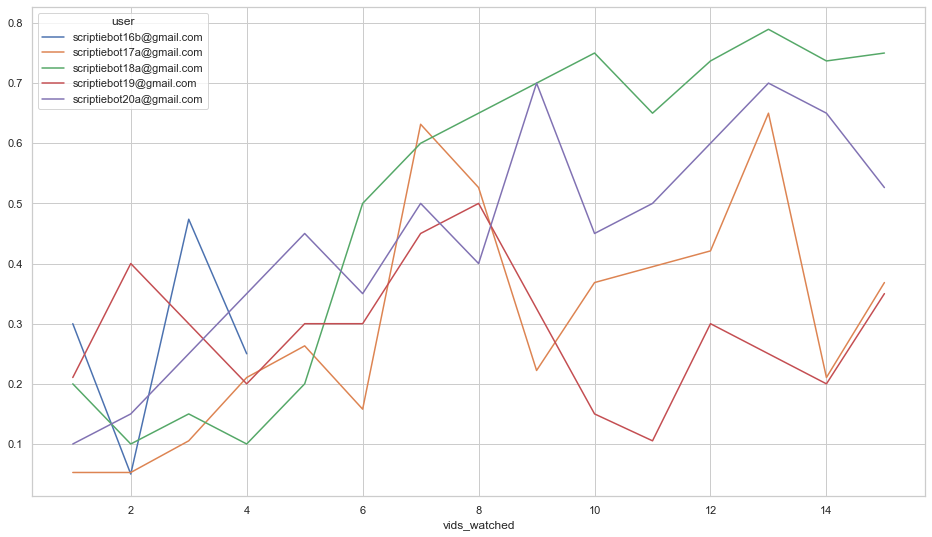

In [261]:
pivot.loc["strategy 4"].T.plot(figsize=(16,9));

## Significance testing

In [224]:
def group(combined, strategy, i):
    return combined[(combined["strategy"] == strategy) & 
                    (combined["vids_watched"] == i)].groupby("user")["conspiracy_pred"].mean().values

In [258]:
results = defaultdict(dict)

for strategy in ["strategy 2", "strategy 3", "strategy 4"]:
    for i in range(1, 16):
        x = group(combined, "strategy 1", i)
        
        y = group(combined, strategy, i)
        results[strategy][i] = ttest_ind(x, y, alternative="smaller")[1]
    
results

defaultdict(dict,
            {'strategy 2': {1: 0.001974886401722661,
              2: 0.16595431931959903,
              3: 0.11101368527699541,
              4: 0.12458001628610821,
              5: 0.07842532370841031,
              6: 0.003385554938704865,
              7: 0.016865195291183122,
              8: 0.00013113737635454635,
              9: 0.00010267777683760482,
              10: 0.0009551465369069643,
              11: 0.002729254083932221,
              12: 0.00018471034114493027,
              13: 0.0001727455252708711,
              14: 0.0003459915410564204,
              15: 0.00018027889442060537},
             'strategy 3': {1: 0.13656961129572026,
              2: 0.27864608112049416,
              3: 0.049925338265930104,
              4: 0.006075670784244487,
              5: 1.2611676274802847e-05,
              6: 0.0028459881918754823,
              7: 0.015393112635205111,
              8: 0.01736673978892123,
              9: 0.001176660353075286,
    

## Plotting significance

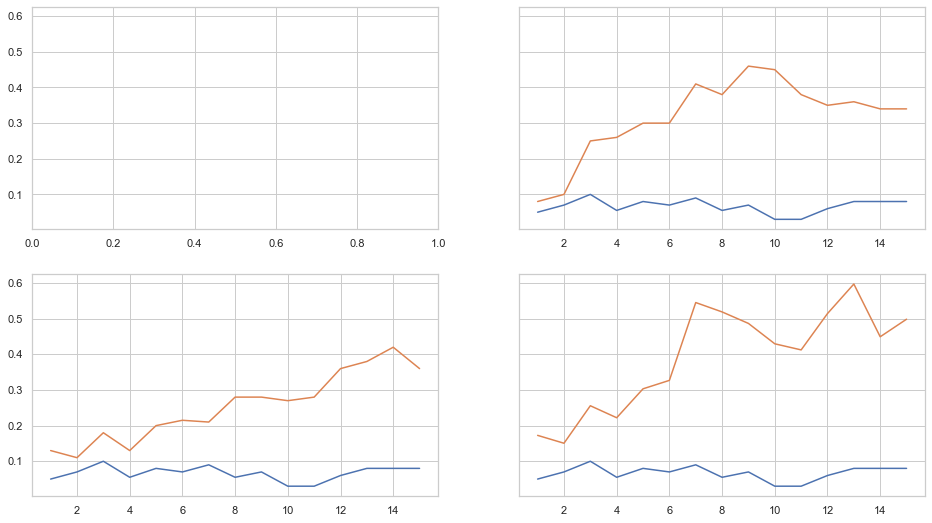

In [260]:
f, ax = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(16, 9));


ax[1, 0].plot(pivot.groupby("strategy").mean().loc[["strategy 1", "strategy 2"]].T);
ax[0, 1].plot(pivot.groupby("strategy").mean().loc[["strategy 1", "strategy 3"]].T);
ax[1, 1].plot(pivot.groupby("strategy").mean().loc[["strategy 1", "strategy 4"]].T);